# Deep Learning: More Recurrent Neural Networks

In [31]:
!pip install torchtext==0.6.0


[notice] A new release of pip is available: 24.0 -> 25.3
[notice] To update, run: C:\Users\ceojo\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [32]:
import torch
import torch.nn as nn
import torchtext
from torchtext.data import Field, LabelField, BucketIterator
from torchtext.datasets import SST
from tqdm import tqdm
import matplotlib.pyplot as plt
torch.manual_seed(12)

print(f"Pytorch version: {torch.__version__}")
print(f"Torchtext version: {torchtext.__version__}")

Pytorch version: 2.9.1+cpu
Torchtext version: 0.6.0



### Note: Python must be 3.11.x

If your kernel shows a value > 3.11.x you will need to downgrade. Please email the staff for help

In [33]:
# DEVICE CONFIGURATION
if torch.backends.mps.is_available():          # Apple Silicon
    device = torch.device("mps")
elif torch.cuda.is_available():                # CUDA GPU
    device = torch.device("cuda")
else:
    device = torch.device("cpu")               # Fallback

print("Using device:", device)

Using device: cpu


In [34]:
!pip install nltk


[notice] A new release of pip is available: 24.0 -> 25.3
[notice] To update, run: C:\Users\ceojo\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [35]:
# Define field types
TEXT = Field(tokenize='basic_english', lower=True, include_lengths=True)
LABEL = LabelField(dtype=torch.float)

# Load SST data
train_data, _, test_data = SST.splits(
    TEXT, LABEL, fine_grained=False
)

In [36]:
# Display size of datasets
print("Train size:", len(train_data))
print("Test size:", len(test_data))

Train size: 8544
Test size: 2210


The `.splits` method is splitting up our dataset so that our train and test sets both have representative samples. 

The `fine_grained` parameter determines how many categories our data is broken into.
- if `True`: labels can be {'positive': 0, 'negative': 1, 'neutral': 2, 'very positive': 3, 'very negative': 4}
- if `False`: labels can be {'positive': 0, 'negative': 1, 'neutral': 2}

In [37]:
# Build vocabulary
MAX_VOCAB_SIZE = 10000
TEXT.build_vocab(train_data, max_size=MAX_VOCAB_SIZE)
LABEL.build_vocab(train_data)

vocab = TEXT.vocab.stoi
pad_idx = TEXT.vocab.stoi[TEXT.pad_token]

### Q: What variable type is `vocab`? What does the `.build_vocab` method do?
Hint: `.stoi` stand for "string to int"!

### A: 
Vocab is a dictionary. The .build_vocab method creates vocab from the training data by counting how often a word appears and making a list of the most common words. 

In [38]:
def decode_dataset(dataset):
    # Reverse label mapping: string -> int
    label_stoi = LABEL.vocab.stoi
    texts = [example.text for example in dataset] 
    labels = [label_stoi[example.label] for example in dataset]
    return texts, labels

train_texts, train_labels = decode_dataset(train_data)
test_texts, test_labels   = decode_dataset(test_data)

### Sanity Check 🧠 
Let's check that the decoded dataset makes sense!

In [48]:
label_map = {idx: word for word, idx in LABEL.vocab.stoi.items()}

# Change i and see what happens!
i = 5

print(" ".join(test_texts[i]))
print(label_map[test_labels[i]])

perhaps no picture ever made has more literally showed that the road to hell is paved with good intentions .
positive


----

Now let's define a `BucketIterator`:

In [40]:
BATCH_SIZE = 32
train_iterator, test_iterator = BucketIterator.splits(
    (train_data, test_data),
    batch_size=BATCH_SIZE,
    sort_within_batch=True,
    sort_key=lambda x: len(x.text),
    device=device
)

Below is a custom classifier:

In [41]:
# Custom LSTM Classifier
class SimpleLSTM(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, pad_idx):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=pad_idx)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, batch_first=False)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, text, text_lengths):
        # text: [batch_size, seq_len] if batch_first=True
        embedded = self.embedding(text)  # [batch_size, seq_len, emb_dim]

        # Pack padded sequence
        packed_embedded = nn.utils.rnn.pack_padded_sequence(embedded, text_lengths.cpu(), batch_first=False, enforce_sorted=False)
        packed_output, (hidden, cell) = self.lstm(packed_embedded)

        # hidden: [1, batch_size, hidden_dim]  -> take the last hidden state
        return self.fc(hidden.squeeze(0))  # [batch_size, output_dim]

Here's a helper function so we can vary parameters later:

In [42]:
# TRAINING LOOP FUNCTION
def run_training_loop(num_epochs, random_state):
    # set random seed
    torch.manual_seed(random_state)

    EMBEDDING_DIM = 100
    HIDDEN_DIM = 256
    OUTPUT_DIM = 1

    # Send model to device
    model = SimpleLSTM(len(vocab), EMBEDDING_DIM, HIDDEN_DIM, OUTPUT_DIM, pad_idx).to(device)
    criterion = nn.BCEWithLogitsLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

    # init output vars
    train_losses = []
    train_accs = []

    # train for num_epochs
    for epoch in range(num_epochs):
        model.train()
        epoch_loss = 0
        epoch_acc = 0

        # Wrap the iterator with tqdm
        for batch in tqdm(train_iterator, desc=f"Epoch {epoch+1}/{num_epochs}"):
            text, text_lengths = batch.text
            labels = batch.label

            text, text_lengths, labels = text.to(device), text_lengths.to(device), labels.to(device)

            optimizer.zero_grad()
            predictions = model(text, text_lengths).squeeze(1)

            # Loss
            loss = criterion(predictions, labels.float())
            loss.backward()
            optimizer.step()

            # Optional: compute accuracy
            preds = torch.round(torch.sigmoid(predictions))
            acc = (preds == labels).float().mean()
            epoch_loss += loss.item()
            epoch_acc += acc.item()
        
        avg_loss = epoch_loss/ len(train_iterator)
        avg_acc = epoch_acc/ len(train_iterator)
        train_losses.append(avg_loss)
        train_accs.append(avg_acc)
        print(f"Loss = {avg_loss:.4f}, Accuracy = {avg_acc:.4f}\n")
    return train_losses, train_accs, model

And another helper function plot the `train_losses` and `train_accs`:

In [43]:
def plot_training_performance(train_losses, train_accs, num_epochs, random_state):
    fig = plt.figure(figsize=(8,4), tight_layout=True)
    fig.suptitle(f"Model Training for State {random_state} over {num_epochs} Epochs")

    plt.subplot(1,2,1)
    plt.plot(train_losses, "-o", label="Train Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.grid()
    plt.legend()

    plt.subplot(1,2,2)
    plt.plot(train_accs, "-o", label="Train Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy (%)")
    plt.grid()
    plt.legend()
    plt.show()


Let's train our model!

In [53]:
NUM_EPOCHS = 15
RANDOM_STATE = 0
train_losses, train_accs, model = run_training_loop(NUM_EPOCHS, RANDOM_STATE)

Epoch 1/15:   0%|          | 0/267 [00:00<?, ?it/s]

Epoch 1/15: 100%|██████████| 267/267 [00:19<00:00, 13.93it/s]


Loss = 0.5134, Accuracy = 0.3971



Epoch 2/15: 100%|██████████| 267/267 [00:17<00:00, 14.94it/s]


Loss = 0.3471, Accuracy = 0.4651



Epoch 3/15: 100%|██████████| 267/267 [00:20<00:00, 13.23it/s]


Loss = -0.3013, Accuracy = 0.5241



Epoch 4/15: 100%|██████████| 267/267 [00:20<00:00, 13.32it/s]


Loss = -1.9882, Accuracy = 0.5645



Epoch 5/15: 100%|██████████| 267/267 [00:21<00:00, 12.60it/s]


Loss = -7.9312, Accuracy = 0.6066



Epoch 6/15: 100%|██████████| 267/267 [00:21<00:00, 12.41it/s]


Loss = -15.8948, Accuracy = 0.6271



Epoch 7/15: 100%|██████████| 267/267 [00:21<00:00, 12.65it/s]


Loss = -27.7586, Accuracy = 0.6564



Epoch 8/15: 100%|██████████| 267/267 [00:20<00:00, 12.85it/s]


Loss = -43.0040, Accuracy = 0.6842



Epoch 9/15: 100%|██████████| 267/267 [00:21<00:00, 12.49it/s]


Loss = -53.9502, Accuracy = 0.6856



Epoch 10/15: 100%|██████████| 267/267 [00:23<00:00, 11.22it/s]


Loss = -67.0001, Accuracy = 0.6971



Epoch 11/15: 100%|██████████| 267/267 [00:24<00:00, 10.80it/s]


Loss = -81.9135, Accuracy = 0.7027



Epoch 12/15: 100%|██████████| 267/267 [00:23<00:00, 11.54it/s]


Loss = -96.8354, Accuracy = 0.7159



Epoch 13/15: 100%|██████████| 267/267 [00:21<00:00, 12.63it/s]


Loss = -110.9551, Accuracy = 0.7226



Epoch 14/15: 100%|██████████| 267/267 [00:22<00:00, 12.12it/s]


Loss = -122.0047, Accuracy = 0.7118



Epoch 15/15: 100%|██████████| 267/267 [00:21<00:00, 12.26it/s]

Loss = -137.5454, Accuracy = 0.7295



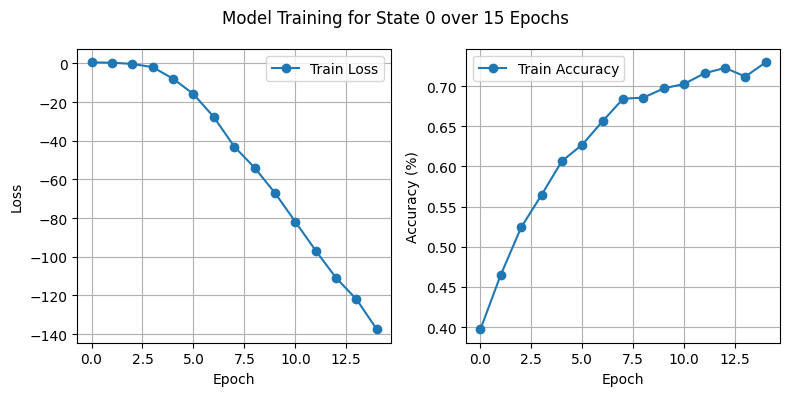

In [54]:
plot_training_performance(train_losses, train_accs, NUM_EPOCHS, RANDOM_STATE)

### Q: Try changing the value of `NUM_EPOCHS`. What happens to the train loss and accuracy plots? What does this tell us about the optimal number of training epochs?

### A: 
Until a certain number of epochs, the training loss decreases and the accuracy increases. However, after a certain number of epochs, the training loss keeps decreasing but the accuracy increases by only a little bit or even decreases. This shows that the optimal number of epochs is just before the accuracy starts decreasing due to overfitting. 

### Q: Try changing the value of `RANDOM_STATE`. What happens to the train loss and accuracy plots? What does this tell us about the impact of the initial guess (i.e. epoch 0)?

### A: 
Changing the random state changes te shape of the train loss and accuracy plots a little bit, but it ends with a similar result. THis shows thar the initial guess can change the shape of the plot, but the resulting performance will be similar. 

----

## Performance on the Test Set

Here's a helper function to run our model on the test data:

In [55]:

# Evaluate on test set
def run_evaluation_test():
    model.eval()
    test_loss, test_acc, = 0,0

    with torch.no_grad():
        for batch in test_iterator:
            text, text_lengths = batch.text
            labels = batch.label

            text = text.to(device)
            text_lengths = text_lengths.to(device)
            labels = labels.to(device)

            criterion = nn.BCEWithLogitsLoss()
            predictions = model(text, text_lengths).squeeze(1)
            loss = criterion(predictions, labels.float())

            preds = torch.round(torch.sigmoid(predictions))
            acc = (preds == labels).float().mean()

            test_loss += loss.item()
            test_acc += acc.item()

    return print(f"Test Accuracy: {100 * test_acc / len(test_iterator):.2f}%")


Finally, let's check that our model can generalize by processing the test data:

In [56]:
run_evaluation_test()

Test Accuracy: 56.47%


----
## Further Exploration 🔎

### Q: What happens to the **test** accuracy as `NUM_EPOCHS` is changed? What does this tell us about our neural network?
Note: remember to re-train your model before running on the test set!

### A:
As the number of epochs increase, the test accuracy increases, but only to a ceratin number of epochs before the model accuracy stays constant or even decreases. This shows that too many epochs doesn't always mean better accuracy. 

### Q: What happens to the **test** accuracy as `RANDOM_STATE` is changed? What does this tell us about our neural network?
Note: remember to re-train your model before running on the test set!

### A:
Changing the random state can change the test accuracy slightly, but it converges to a certain range of accuracy after training. 

### Q: What happens to your results if you set `find_grained=True`?
Try to predict first and then test your hypothesis by changing the value and re-running the notebook!

### A: 
Setting the find_grained-True changes the results slightly and it might make the results more accurate. 